## Profiling LSF, SGD & DMRG

#### Memory, Latency & Instability

The results for this plot are obtained by running `python scripts/profile_models.py`

In [ ]:
# Instability
import torch
from tqdm import tqdm
from ctn.mheads import MHEADS
from ctn.mheads._abc import AbstractDisributionHeadConfig
import pandas as pd

# Common HPs
BATCH_SIZE = 8
LR = 1e-3
N_ITERS = 10000
SEED = 0

# Model hps
H, R, Do = 100, 8, 2

models = [
    {"name": r"LSF", "model": "mps", "iters": 0, "kwargs": {}},
    {"name": r"SGD", "model": "mps", "iters": 0, "kwargs": {"use_scale_factors": False}},
]

for mdict in models:
    model = MHEADS[mdict["model"]](
        config=AbstractDisributionHeadConfig(
            rank=R,
            d_model=1,
            d_output=Do,
            horizon=H,
            **mdict["kwargs"]
        )
    )
    for i in tqdm(range(N_ITERS)):
        x = torch.randn(BATCH_SIZE, 1)
        y = torch.randint(0, Do, (BATCH_SIZE, H))
        try:
            if hasattr(model, "train_example"):
                model.train_example(x, y)
            else:
                model(x, y)
            mdict["iters"] += 1
        except Exception as e:
            break


df = pd.DataFrame(models)[["name", "iters"]]

print("Max iterations: reached for each model")
print(df)


 17%|█▋        | 1703/10000 [00:33<02:39, 51.92it/s]

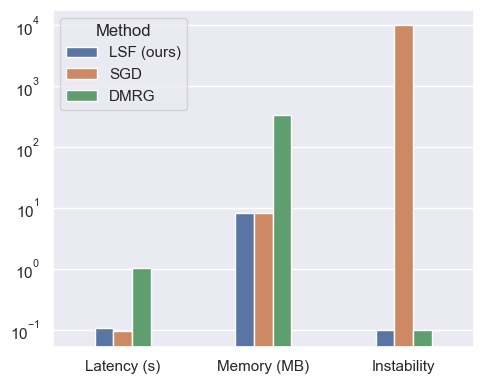

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CPU Results (D=2)
#     latency  peak_memory_MB name   R    H  Do  Di   B sweep_type  sweep_value                                                                                                                                          
# 0  1.208001        1.570201   bm  32  128   2   1  32          H          128
# 1  0.161665        0.231740  mps  32  128   2   1  32          H          128
# 2  0.039397        0.706291   bm  32    8   2   1  32         Do            2
# 3  0.010879        0.017302  mps  32    8   2   1  32         Do            2

# GPU Results (D=2)
#     latency  peak_memory_MB name   R    H  Do  Di   B sweep_type  sweep_value                                                                                                                                          
# 0  0.824485       59.143555   bm  32  128   2   1  32          H          128
# 1  0.228930      125.894531  mps  32  128   2   1  32          H          128

sns.set_theme()

instability_fn = lambda N: 10000 - N + 0.1

# Data
df_latency_mem = pd.DataFrame({
    "Method": ["LSF (ours)", "SGD", "DMRG"],
    "Latency (s)": [0.11, 0.095, 1.04], # for d=1024, h=5
    "Memory (MB)": [8.5, 8.5, 334],  # for d=1024, h=5
    "Instability": [instability_fn(10000), instability_fn(0), instability_fn(10000)],
})

# Melt the dataframe for easier plotting with seaborn
df_melted = df_latency_mem.melt(id_vars="Method", var_name="Metric", value_name="Value")

plt.figure(figsize=(5, 4))  # smaller width
sns.barplot(
    data=df_melted,
    x="Metric",
    y="Value",
    hue="Method",
    width=0.4  # Make bars skinnier (default is 0.8)
)
plt.yscale("log")
ax = plt.gca()
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.tight_layout()
plt.show()

#### Instability